In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import IPython.display as ipd
from IPython.display import clear_output
%matplotlib inline

In [2]:
root_path="C:/Users/sarib/Desktop/Gohm/SpeechRecognition/database"

In [3]:
def get_spectrogram(file):
    signal, sample_rate = librosa.load(file)
    ipd.Audio(file)
    melspectrogram = librosa.feature.melspectrogram(signal)
    S_DB = librosa.power_to_db(melspectrogram, ref=np.max)
    return S_DB

In [4]:
ac=get_spectrogram('C:/Users/sarib/Desktop/Gohm/SpeechRecognition/database/ac/ac_AHCG_FYAOGEJ.wav')
ac.shape

C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[0.00029784 0.00029709 0.00020588 ... 0.00210502 0.00255697 0.00117369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)


(128, 44)

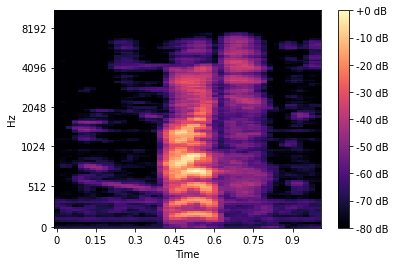

In [5]:
librosa.display.specshow(ac, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [6]:
extracted_feataures =[]
for root, directories, files in os.walk(os.path.join(root_path,"dataset1")):
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names))
            data = get_spectrogram(os.path.join(root,file_names))
            extracted_feataures.append([data,os.path.basename(os.path.normpath(root))])

C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[-5.9660564e-05 -1.7664862e-04 -3.6537624e-04 ...  1.0201340e-04
  1.3263593e-04  5.8844234e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[5.3346873e-04 6.3750986e-04 6.4097950e-04 ... 1.2940567e-04 9.3590417e-05
 3.9358496e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960

In [7]:
extracted_feataures_dataframe= pd.DataFrame(extracted_feataures, columns=["melspectrogram", "word"])
extracted_feataures_dataframe.head()

,melspectrogram,word
0,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -67.93292...",ac
1,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",ac
2,"[[-80.0, -79.9106, -79.177635, -80.0, -80.0, -...",ac
3,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",ac
4,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",ac


In [8]:
extracted_feataures_dataframe['word'].value_counts()

ac        5
asagi     5
baslat    5
devam     5
dur       5
evet      5
geri      5
hayir     5
ileri     5
iptal     5
kapa      5
sag       5
sol       5
yukari    5
Name: word, dtype: int64

In [9]:
X=np.array(extracted_feataures_dataframe['melspectrogram'].tolist())
Y=np.array(extracted_feataures_dataframe['word'].tolist())

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
Y_numerical=to_categorical(labelencoder.fit_transform(Y))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X,Y_numerical, test_size=0.2, random_state=0)

In [12]:
INPUT_SHAPE=(128,44,1)

In [13]:
X_test.shape

(14, 128, 44)

TRANSFER LEARNING

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,44,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,44,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,44,1)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(Y_numerical.shape[1],activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 42, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 9, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 7, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [17]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=0.001))

In [18]:
checkpointpath="checkpoint/cp.ckpt"
checkpointer = ModelCheckpoint(checkpointpath, monitor='val_accuracy',
                               verbose=2, save_best_only=True, mode='max')

history=model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=2)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to checkpoint\cp.ckpt
INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets
2/2 - 3s - loss: 19.7569 - accuracy: 0.0714 - val_loss: 13.8589 - val_accuracy: 0.0000e+00 - 3s/epoch - 1s/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.00000 to 0.21429, saving model to checkpoint\cp.ckpt
INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets
2/2 - 4s - loss: 20.2141 - accuracy: 0.0357 - val_loss: 3.3380 - val_accuracy: 0.2143 - 4s/epoch - 2s/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.21429
2/2 - 1s - loss: 4.6459 - accuracy: 0.1071 - val_loss: 2.5465 - val_accuracy: 0.0714 - 617ms/epoch - 308ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.21429
2/2 - 1s - loss: 2.7168 - accuracy: 0.0893 - val_loss: 2.6346 - val_accuracy: 0.0714 - 588ms/epoch - 294ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.21429
2/2 - 1s - loss: 2.6210 - accuracy: 0.1250 

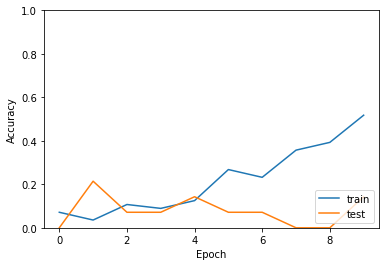

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [20]:
print("Test Score: ", model.evaluate(X_test,Y_test))
print("Train Score: ", model.evaluate(X_train,Y_train))

1/1 [==============================] - 0s 67ms/step - loss: 3.0955 - accuracy: 0.1429
Test Score:  [3.095487594604492, 0.1428571492433548]
2/2 [==============================] - 0s 57ms/step - loss: 1.6533 - accuracy: 0.5714
Train Score:  [1.6532862186431885, 0.5714285969734192]


In [21]:
model.load_weights(checkpointpath)

In [22]:
print("Test Score: ", model.evaluate(X_test,Y_test))
print("Train Score: ", model.evaluate(X_train,Y_train))

1/1 [==============================] - 0s 70ms/step - loss: 3.3380 - accuracy: 0.2143
Test Score:  [3.338024854660034, 0.2142857164144516]
2/2 [==============================] - 0s 38ms/step - loss: 6.0566 - accuracy: 0.0893
Train Score:  [6.056613445281982, 0.0892857164144516]


ADDING SECOND DATASET

In [23]:
extracted_feataures2 =[]
for root, directories, files in os.walk(os.path.join(root_path,"dataset2")):
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names))
            data = get_spectrogram(os.path.join(root,file_names))
            extracted_feataures2.append([data,os.path.basename(os.path.normpath(root))])

C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[ 8.9784060e-04  1.2294345e-03  9.7495673e-04 ... -1.3378418e-04
 -6.0058883e-05 -8.6978675e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[-0.00012486 -0.00048789 -0.00067051 ...  0.00040196  0.00030053
  0.00017929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: Futur

In [24]:
extracted_feataures_dataframe2= pd.DataFrame(extracted_feataures2, columns=["melspectrogram", "word"])
extracted_feataures_dataframe2.head()

,melspectrogram,word
0,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -5...",ac
1,"[[-48.614918, -47.0671, -51.5097, -51.796127, ...",ac
2,"[[-77.81896, -78.91149, -79.056335, -74.97493,...",ac
3,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",ac
4,"[[-51.851547, -47.024128, -50.51588, -60.33071...",ac


In [25]:
extracted_feataures_dataframe2['word'].value_counts()

ac        6
asagi     5
baslat    5
devam     5
dur       5
evet      5
geri      5
hayir     5
ileri     5
iptal     5
kapa      5
sag       5
sol       5
yukari    5
Name: word, dtype: int64

In [26]:
X2=np.array(extracted_feataures_dataframe2['melspectrogram'].tolist())
Y2=np.array(extracted_feataures_dataframe2['word'].tolist())

In [27]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder2=LabelEncoder()
Y_numerical2=to_categorical(labelencoder.fit_transform(Y2))

In [28]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, Y_train2, Y_test2= train_test_split(X2,Y_numerical2, test_size=0.2, random_state=0)

In [29]:
history2=model.fit(X_train2, Y_train2, epochs=10, validation_data=(X_test2, Y_test2), verbose=2)

Epoch 1/10
2/2 - 0s - loss: 4.9435 - accuracy: 0.0714 - val_loss: 2.5094 - val_accuracy: 0.1333 - 414ms/epoch - 207ms/step
Epoch 2/10
2/2 - 0s - loss: 2.6933 - accuracy: 0.0536 - val_loss: 2.6255 - val_accuracy: 0.2667 - 325ms/epoch - 163ms/step
Epoch 3/10
2/2 - 0s - loss: 2.6250 - accuracy: 0.0893 - val_loss: 2.5886 - val_accuracy: 0.1333 - 341ms/epoch - 170ms/step
Epoch 4/10
2/2 - 0s - loss: 2.6162 - accuracy: 0.0893 - val_loss: 2.7726 - val_accuracy: 0.0000e+00 - 329ms/epoch - 165ms/step
Epoch 5/10
2/2 - 0s - loss: 2.5412 - accuracy: 0.1250 - val_loss: 2.9731 - val_accuracy: 0.0667 - 311ms/epoch - 156ms/step
Epoch 6/10
2/2 - 0s - loss: 2.3790 - accuracy: 0.2679 - val_loss: 2.9044 - val_accuracy: 0.1333 - 330ms/epoch - 165ms/step
Epoch 7/10
2/2 - 0s - loss: 2.3227 - accuracy: 0.4107 - val_loss: 2.9826 - val_accuracy: 0.1333 - 339ms/epoch - 169ms/step
Epoch 8/10
2/2 - 0s - loss: 2.0950 - accuracy: 0.4107 - val_loss: 3.1784 - val_accuracy: 0.2000 - 322ms/epoch - 161ms/step
Epoch 9/10
2

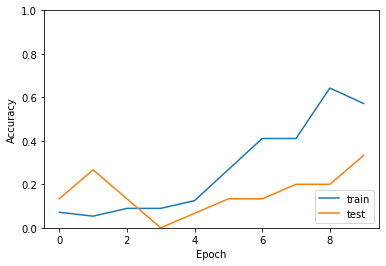

In [30]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [31]:
print("Test Score: ", model.evaluate(X_test2,Y_test2))
print("Train Score: ", model.evaluate(X_train2,Y_train2))

1/1 [==============================] - 0s 71ms/step - loss: 2.7675 - accuracy: 0.3333
Test Score:  [2.7675366401672363, 0.3333333432674408]
2/2 [==============================] - 0s 39ms/step - loss: 1.4511 - accuracy: 0.6607
Train Score:  [1.4511386156082153, 0.6607142686843872]


In [32]:
print("Test Score: ", model.evaluate(X_test,Y_test))
print("Train Score: ", model.evaluate(X_train,Y_train))

1/1 [==============================] - 0s 53ms/step - loss: 2.6807 - accuracy: 0.2143
Test Score:  [2.6806769371032715, 0.2142857164144516]
2/2 [==============================] - 0s 50ms/step - loss: 1.8593 - accuracy: 0.4107
Train Score:  [1.8592844009399414, 0.4107142984867096]


**PREDICTION WITH DATA**

In [33]:
predictiondata_feataures =[]
counter_true=0
for root, directories, files in os.walk("C:/Users/sarib/Desktop/Gohm/SpeechRecognition/RecordsFromDataset"): 
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names) )
            r = get_spectrogram(os.path.join(root,file_names))
            #rl=r.reshape(1,-1)
            rl = r[np.newaxis, ...]
            predicted_label=np.argmax(model.predict(rl), axis=1)
            prediction_class = labelencoder.inverse_transform(predicted_label) 
            predictiondata_feataures.append([os.path.basename(os.path.normpath(root)), prediction_class, predicted_label])
            if os.path.basename(os.path.normpath(root))==prediction_class:
                counter_true+=1

C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[ 1.2192075e-04  2.2335145e-04  2.5522904e-04 ...  1.8752960e-05
 -1.5620921e-05  4.6200835e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[ 0.00041042  0.00018144 -0.00019751 ...  0.00013579 -0.00047579
 -0.00049674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_1588\3768912960.py:4: FutureWarning: Pass y=[6.5817434e-04 9.3733420e-04 9.5855736e-04 ... 2.3620379e-04 2.2297850e-04
 9.9829907e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\U

In [34]:
predictiondata_feataures_dataframe= pd.DataFrame(predictiondata_feataures, columns=["actual data", "predicted data", "predicted data code"])
percentage= (counter_true/len(predictiondata_feataures))*100
print("The percantage of the true predicted data: ", percentage,"%")
#predictiondata_feataures_dataframe.to_csv("output.csv")
predictiondata_feataures_dataframe

The percantage of the true predicted data:  35.714285714285715 %


,actual data,predicted data,predicted data code
0,ac,[ac],[0]
1,ac,[ac],[0]
2,ac,[sag],[11]
3,asagi,[asagi],[1]
4,asagi,[asagi],[1]
5,asagi,[asagi],[1]
6,baslat,[baslat],[2]
7,baslat,[baslat],[2]
8,baslat,[baslat],[2]
9,devam,[sag],[11]
